# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import project_tests as t
import pickle
from sklearn.metrics import f1_score

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [2]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
df.shape

(45993, 3)

In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [5]:
df_content.shape

(1056, 5)

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

(array([4.915e+03, 1.670e+02, 4.600e+01, 1.100e+01, 7.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  1. ,  37.3,  73.6, 109.9, 146.2, 182.5, 218.8, 255.1, 291.4,
        327.7, 364. ]),
 <a list of 10 Patch objects>)

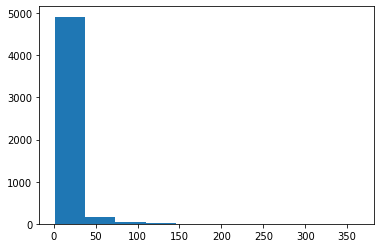

In [6]:
df_email=df.groupby('email').count()
plt.hist(df_email['article_id'])


In [7]:
# Fill in the median and maximum number of user_article interactios below
print(df_email['article_id'].median())
print(df_email['article_id'].max())

3.0
364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles
# check number of duplicates
df_content.duplicated().sum()

0

In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content['article_id'].duplicated().sum()

5

In [10]:
# check if the duplicates have been removed
df_content.drop_duplicates('article_id',inplace=True)
df_content['article_id'].duplicated().sum()

0

In [11]:
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [12]:
print(df['article_id'].nunique())
print(df_content['article_id'].nunique())
print(df['email'].nunique())
print(df.shape[0])


714
1051
5148
45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
df_by_article_id=df.groupby('article_id').count()
df_by_article_id.sort_values('title',ascending=False).head()

,title,email
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627


In [14]:
df_by_article=df_by_article_id.sort_values('title',ascending=False)['title']
most_viewed_article=str(df_by_article.values[0])
print(most_viewed_article)

937


In [15]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [16]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell


# Test your dictionary against the solution


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [17]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    df_by_title=df.groupby('title').count()
    
    df_sorted_title= df_by_title.sort_values('article_id',ascending=False)['article_id']
    
    top_articles=[]
    
    # Return the top article titles from df (not df_content)
    for i in range(0,n):
        top_articles.append(df_sorted_title.index[i])
    return top_articles
   
       
    

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    df_article_ids=df_by_article_id.sort_values('title',ascending=False)['title']
    top_ids=[]
    # Return the top article ids
    for i in range(0,n):
        top_ids.append(df_article_ids.index[i])
    return  top_ids

In [18]:
# get top articles ids
get_top_article_ids(5, df)

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0]

In [19]:
# Test your function by returning the top 5, 10, and 20 articles

#get_top_articles(5, df))
get_top_articles(10,df)
#get_top_articles(20,df)



['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item_df=df.groupby('user_id')['article_id'].value_counts().unstack().fillna(0)
    user_item_df[user_item_df > 1]=1
      
    # return the user_item matrix 
    return  user_item_df

user_item = create_user_item_matrix(df)

In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [22]:
from scipy import spatial

def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    # compute similarity of each user to the provided user
    similarity = pd.DataFrame(np.dot(user_item[user_item.index == user_id],user_item.T),columns=user_item.index)
    
    # sort by similarity
    similarity = similarity.sort_values(0,axis=1, ascending=False)
    # create list of just the ids and # remove the own user's id
    most_similar_users = similarity.columns.tolist()
    
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar

In [23]:
# Do a spot check of your function
find_similar_users(1)[:10]


[3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [30]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Find the names of the articles by modifying the list of articles and names and subseting on the article_ids
   # df_article_names=pd.DataFrame(df.groupby('article_id')['title'],columns=['article_id','title'])
    #df_article_names.reset_index(drop=True, inplace=True)
    #df_article_names=df_article_names[df_article_names['article_id'].isin(article_ids)]
    df_new=df.copy()
    df_new=df_new.drop_duplicates(inplace=True)
    df_article_names=df_new[df_new['article_id'].isin(article_ids)]['title'].tolist()

    
    
    # Return the article names associated with list of article ids
    return df_article_names


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # get the articles ids by selecting the columns that are = 1 for the selected user_id
    user_articles_ids=user_item.columns[user_item.loc[user_id]==1].tolist()
    user_articles_ids=list(map(str,user_articles_ids))
    
    
    # find the names of the articles using the function defined before
    articles_names=get_article_names(user_articles_ids, df=df)
   
    
     # return the ids and names
    return user_articles_ids,articles_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs=[]
    i=1
    most_similar_users=find_similar_users(user_id, user_item)
    articles_read=get_user_articles(user_id)[0]
   
    while len(recs) < m:
         # list of the articles read by the i similar user
        similar_read=get_user_articles(i)[0]
       
         # identify the articles that where not already read by the user
        not_read_article=list(set(similar_read)-set(articles_read))
    
         # identify the articles that where not already recommended to the user
        not_rec=list(set(not_read_article)-set(recs))
    
         # add the new recommendations to the recommendation list
        recs.extend(not_rec)
    
        # itarion through the next similar user
        i+=1
       
        # break the loop if he already iterated through all the similar users
        if i > len(most_similar_users):
            break
        else:
            pass     
    
         # add random article to the recommandation list if < m or cut if too many article
        if len(recs) < m:
            recs.extend(df['article_id'].tolist())
            recs=recs[:m]
        if len(recs) == m:
            recs = recs
        elif len(recs) > m:
            recs = recs[:m]
            
    # return your recommendations for this user_id   
    return recs

In [31]:
# Check Results
# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10))

TypeError: 'NoneType' object is not subscriptable

In [29]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

TypeError: 'NoneType' object is not subscriptable

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [28]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # Your code here
    
    # sort by similarity
   
    # create list of just the ids
    
    # remove the own user's id
   
    
     # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    
    # list of the articles read by the i similar user
        
        
    # order them by most interactions   
        
    # identify the articles that where not already read by the user
       
    # identify the articles that where not already recommended to the user
       
    # add the new recommendations to the recommendation list
       
    # itarion through the next similar user
        
    # break the loop if whe already iterated through all the similar users
        
    
    # add random article to the recommandation list if < m or cut if too many article
   
    
    

In [6]:
# Quick spot check - don't change this code - just use it to test your functions


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [30]:
### Tests with a dictionary of results


In [7]:
## Dictionary Test Here


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

The most read or most trending articles have a higher probability to be interesting to our new user in comparison with an article with very few read. After after a few article read by the user we can start to recommand articles read by similar users or with similar subjects,...

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [32]:

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [34]:
# importing the libraries needed for the text analysis
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [35]:
# tokenizing function
def tokenize(text):
    '''
    INPUT: a unstructured text
    
    OUTPUT: clean tokens lowered,lemmatized, stop words removed
    
    '''
    # normalize case and remove punctuation
    

In [8]:
# tokenization of the doc_full_name column of the df_content DataFrame and register in a python Dictionnary


In [9]:
# tokenization of the doc_description column of the df_content DataFrame and register in a python Dictionnary


In [38]:
def make_content_recs(search=['python','data'],number_recommendation=5):
    '''
    INPUT: 
        - search : 1 or more search terms
        - number_recommendation : the maximum number of recommandation that we want to obtain
    
    OUTPUT:
        - list_results_name : a list of article names containing one or more of the search terms inside their article description
        ordered by popularity with a maximum of articles defined with the 'number_recommendation'
    
    '''
    
# list articles containing the search term and ordered by frequency of reading
    

    

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Content based recommendation system**

I wrote a recommendation system based on a research term indicated by the user. The recommender first tokenize the words in the description of all the articles and then return a list of the most consulted articles that contains theses words.

A next step could be to identify the frequent terms that the user consults and recommend him articles based on thoses terms.
Another improvement could be to identify the terms in the 'doc_body'column but the tokenization step was quite time consuming for my local computer.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [40]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [41]:
# Load the matrix here


In [10]:
# quick look at the matrix


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [44]:
# Perform SVD on the User-Item Matrix Here
# use the built in to get the three matrices

There is no missing values in the matrices so we can use SVD without performing any data imputation.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [11]:

    # restructure with k latent features
   
    
    # take dot product
    
    
    # compute error for each prediction to actual value
   
    
    # total errors and keep track of them
    

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many movies can we make predictions for in the test set?  
* How many movies are we not able to make predictions for because of the cold start problem?

In [48]:


def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    #df_train.groupby('user_id')['article_id'].value_counts().unstack().fillna(0)
    
    #df_test.groupby('user_id')['article_id'].value_counts().unstack().fillna(0)
    
   

In [12]:
# Replace the values in the dictionary below


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [53]:
# fit SVD on the user_item_train matrix
# fit svd similar to above then use the cells below

In [13]:
# users in test set that can be predicted (because also in training set)


In [14]:
# movies in test set that can be predicted (because also in training set)


In [15]:
# calculating the balance of the reduced test dataset


In [62]:
# the latent_features matrix remains the same as for the training set

In [16]:
# Use these cells to see how well you can use the training

    
    # restructure with k latent features
   
    
    # take dot product
   
    
    # compute error for each prediction to actual value
   
    
    # total errors and keep track of them
    
    
    #print('0 correclty identified : {} | 1 correcly identifed : {}'.format())
    # decomposition to predict on test data

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Results description**
We observe that we have an increasing training accuracy untill around 300 latent features and then the increase is marginal. In the same time the testing accuracy remains above 0.93 while increasing the latent features. This could seems like a pretty good result but the classes are very unbalanced and the accuracy poorly represents the ability to correcly predict if the user saw a movie or not.

The F1_score is a better indicator and in this case the training F1_score also drasticly reduce to increase around 300 latent features. The F1_score on the other and remains very low with a maximum of 0.131 at 90 latent features.

The main problem in with this method for this dataset is that we have a very low number of users (20) for which we can make predictions. A larger dataset should enable to improve the results.

From the different systems that we observed I would prefer to implement :
    - for the new users, given the cold start problem a Rank Based Recommendations system
    - for the users that already have read a few articles, a combination of content based recommendation, User-User Based Collaborative Filtering and Rank Based Recommendations in order to take profit of most of the information contained in the database
    - When the database expand and when we will have more data we could move to a solution using SVD.
    
In order to validate these assumption we could implement an A/B test on the plateform by dividing the audicence in different groups and applying them different types of recommandations algorithms and see which of the algorithms gives the best recommandations to the users.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 